In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
SROUTE = [
    '400860-400861', 
    '400861-403781',
#     '400861-400948',
    '400861-405376',
]
ADJ = {}
ADJ[SROUTE[0]] = [SROUTE[1], SROUTE[2]]
# ADJ[SROUTE[0]] = []
ADJ[SROUTE[1]] = [SROUTE[0]]
ADJ[SROUTE[2]] = [SROUTE[0]]

DENSE = False
EPS = 120
LAG = 24 + 1
HSIZE = 128
STOPS = len(SROUTE)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [4]:
# dset = SpotHistory(SROUTE, 'train', 32, lag=LAG, res=10).generator()
dset = SpotHistory(SROUTE, 'train', 32, lag=LAG, res=10).generator()
evalset = SpotHistory(SROUTE, 'test', 32, lag=LAG, res=10).generator()

Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
    * [400861-403781]: 90
    * [400861-405376]: 90
 [*] Examples (train): 10227
 [*] Time range: 2014-08-01 ~ 2014-10-31
Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
    * [400861-403781]: 90
    * [400861-405376]: 90
 [*] Examples (test): 10227
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [5]:
from models.temporal.RNN import *
from models.MPRNN import *

model = CMPN(
    nodes=SROUTE, adj=ADJ, 
    hidden_size=HSIZE, 
    
    rnnmdl=RNN_MIN,
    mpnmdl=MP_DENSE,
    
    verbose=True).to(device)
model.device = device
criterion, opt, sch = model.params(lr=0.05)

model.clear_stats()
evf = lambda: evaluate(evalset, model, crit=lambda _y, y: criterion(_y[:, :, 0], y[:, :, 0]).item())
_ = evf()

MPRNN
 [*] Defined over: 3 nodes
 [*] Contains    : 3 adjs
Eval loss: 114.38947    


In [ ]:
losses = []
eval_mse = []
eval_mape = []
from numpy.random import randint
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item()
        ))
    sys.stdout.write('\n')

    eval_mse.append(evf())
    sys.stdout.flush()
    sch.step()

[1/120 : 320/320] - L1.44       
Eval loss: 1.60754    
[2/120 : 320/320] - L1.27      
Eval loss: 1.31568    
[3/120 : 320/320] - L0.95      
Eval loss: 0.69667    
[4/120 : 320/320] - L0.56      
Eval loss: 0.63365    
[5/120 : 320/320] - L0.78      
Eval loss: 0.83988    
[6/120 : 320/320] - L0.21      
Eval loss: 0.44544    
[7/120 : 320/320] - L0.78      
Eval loss: 0.76665    
[8/120 : 320/320] - L0.75      
Eval loss: 1.01343    
[9/120 : 320/320] - L0.52      
Eval loss: 0.53709    
[10/120 : 320/320] - L0.55      
Eval loss: 0.47843    
[11/120 : 320/320] - L0.47      
Eval loss: 0.30450    
[12/120 : 320/320] - L0.26      
Eval loss: 0.28428    
[13/120 : 320/320] - L0.93      
Eval loss: 1.01138    
[14/120 : 320/320] - L0.70      
Eval loss: 0.62445    
[15/120 : 320/320] - L0.32      
Eval loss: 0.39315    
[16/120 : 320/320] - L0.14      
Eval loss: 0.24048    
[17/120 : 320/320] - L0.16      
Eval loss: 0.26585    
[18/120 : 320/320] - L0.20      
Eval loss: 0.22352    


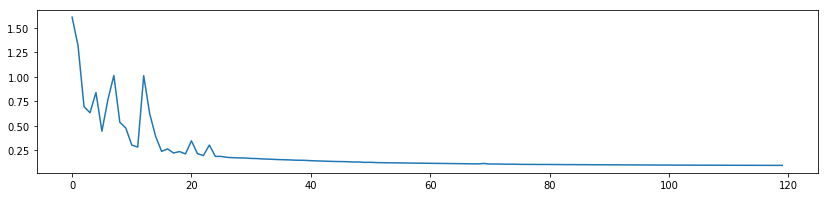

In [7]:
plt.figure(figsize=(14, 3))
plt.plot(eval_mse)
plt.show(); plt.close()

In [8]:
from utils import *
viewset = SpotHistory(SROUTE, 'test', 16, lag=None, res=10, shuffle=False, verbose=False)
def xfmt(datain):
    bynode = torch.split(datain.to(device).float().unsqueeze(1), 1, 2)
    return bynode

In [9]:
# torch.save(model.state_dict(), 'checkpoints/mpnn_n3.pth')
# torch.save(model, 'checkpoints/mpnn_n3_full.pth')

In [11]:
model.steps=3

Eval segments: 18
Eval MSE: 99.0338


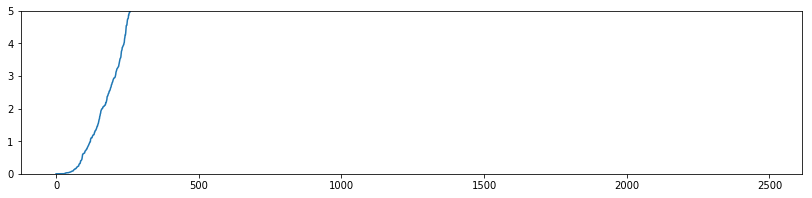

In [12]:
sqerr = eval_rnn(viewset, model, plot=False, xfmt=xfmt)
print('Eval segments:', len(viewset))
print('Eval MSE: %.4f' % np.mean(sqerr))

plt.figure(figsize=(14, 3))
plt.plot(sorted(sqerr)); plt.ylim(0, 5)
plt.show(); plt.close()

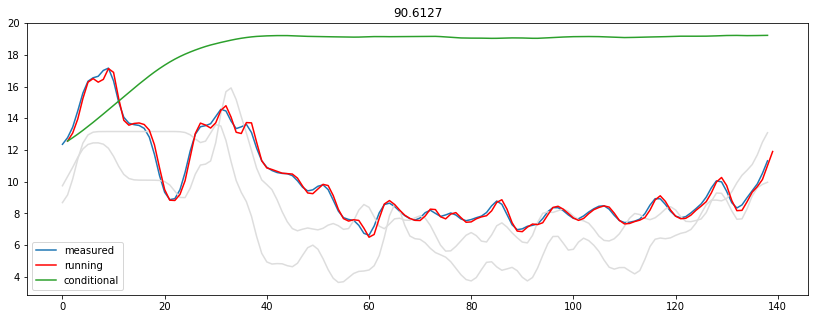

In [13]:
_ = eval_rnn(viewset[:1], model, plot=True, xfmt=xfmt)